In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')


In [62]:
df = pd.read_csv('Boston_Housing.csv')

In [63]:
df = df.drop(df.columns[-1], axis=1)

In [64]:
# df = df[~(df['MEDV'] >= 50.0)]
# print(np.shape(df))

D'après la matrice de corrélation de Pearson (cf rapport) :
- TAX et RAD très corrélées l'une à l'autre (0.91)
- RM, LSAT, PTRATIO, INDUS, NOX, TAX très corrélées à MEDV (> 0.50)
- CRIM, ZN, AGE, RAD corrélation moyenne à MEDV ( entre 0.5 et 0.4)
- CHAS, DIS B très peu corrélés à MEDV (<0.4)

## Modélisation

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor



## Feature Importance

En croisant ces info, on décide de supprimer les features : 
- ZN (car conditionnelle au lot de plus de 25000 sqft)
- B

In [74]:
from sklearn.metrics import accuracy_score
model_gbr = GradientBoostingRegressor()

In [75]:
X = df.drop(['MEDV', 'ZN', 'B'], axis=1)
y = df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
numerical_features2 = ['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'LSTAT', 'RAD']
numerical_transformer = StandardScaler()

preprocessor2 = ColumnTransformer(
    transformers=[
        
        ('num', numerical_transformer, numerical_features2),
    ], remainder="passthrough"
)

In [77]:
pipe_gbr2 = Pipeline([
     ('prep', preprocessor2),
     ('model', model_gbr)
])

# Entrainement sur X_train
trained_model_gbr2 = pipe_gbr2.fit(X_train,y_train)

# scoring sur X_test
print(trained_model_gbr2.score(X_test, y_test))

0.9162663650408793


Hyperparamètres par défaut :  
- n_estimators : 100
- learning_rate : 0.1
- max_depth : 3
- min_samples_split : 2
- min_samples_leaf : 1
- max_features : None

## Recherche des meilleurs hyperparamètres (Optuna)

In [78]:
import optuna

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])
    subsample = trial.suggest_float('subsample', 0.1, 1.0)

    model = GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        subsample=subsample
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    return r2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Meilleurs hyperparamètres:", study.best_params)
print("R2 avec les meilleurs hyperparamètres:", study.best_value)

[I 2023-06-12 16:44:06,188] A new study created in memory with name: no-name-5830578a-6260-4396-8b92-999110108934
[I 2023-06-12 16:44:07,965] Trial 0 finished with value: 0.9159559475782 and parameters: {'learning_rate': 0.08318716737510658, 'n_estimators': 1000, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'auto', 'subsample': 0.9437001863441857}. Best is trial 0 with value: 0.9159559475782.
[I 2023-06-12 16:44:08,073] Trial 1 finished with value: 0.7593565470251501 and parameters: {'learning_rate': 0.0674738296640918, 'n_estimators': 200, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'subsample': 0.1117668160637792}. Best is trial 0 with value: 0.9159559475782.
[I 2023-06-12 16:44:08,181] Trial 2 finished with value: 0.8972139194372826 and parameters: {'learning_rate': 0.042609431502866814, 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'log2', 'subsample':

Meilleurs hyperparamètres: {'learning_rate': 0.08196986327244557, 'n_estimators': 600, 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'auto', 'subsample': 0.9690966801015517}
R2 avec les meilleurs hyperparamètres: 0.9348808635474167


Meilleurs hyperparamètres: {'learning_rate': 0.035117389101753244, 'n_estimators': 600, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'subsample': 0.9814010294265737}
R2 avec les meilleurs hyperparamètres: 0.933300536709442

## Entrainement du modèle avec les meilleurs hyperparamètres défini avec Optuna

In [81]:
# Création du nouveau modèle avec les meilleurs hyperparamètres
best_params = study.best_params
model_gbr_best = GradientBoostingRegressor(**best_params)

# Création du pipeline avec le nouveau modèle et le préprocesseur
pipe_gbr2 = Pipeline([
     ('prep', preprocessor2),
     ('model', model_gbr_best)
])

# Réinitialiser X_train, X_test, y_train, y_test pour le deuxième modèle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement sur X_train
trained_model_gbr2 = pipe_gbr2.fit(X_train, y_train)

# Scoring sur X_test
print(trained_model_gbr2.score(X_test, y_test))

#0.9315251900970233

0.9165981239180191


## Courbe d'apprentissage

In [82]:
from sklearn.model_selection import learning_curve

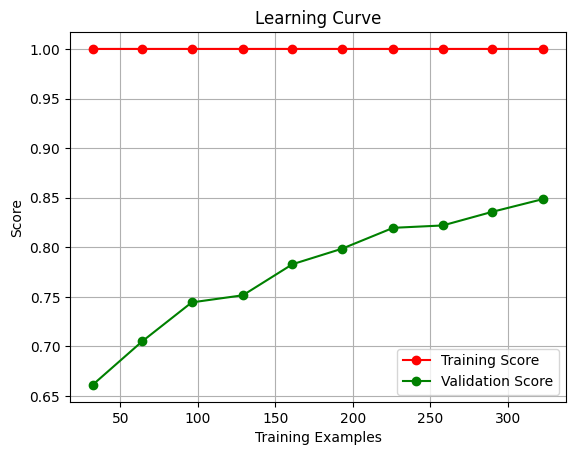

In [83]:
# Calculer les scores d'apprentissage et de validation
train_sizes, train_scores, val_scores = learning_curve(trained_model_gbr2, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calculer les moyennes des scores
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation Score")

plt.legend(loc="best")
plt.show()


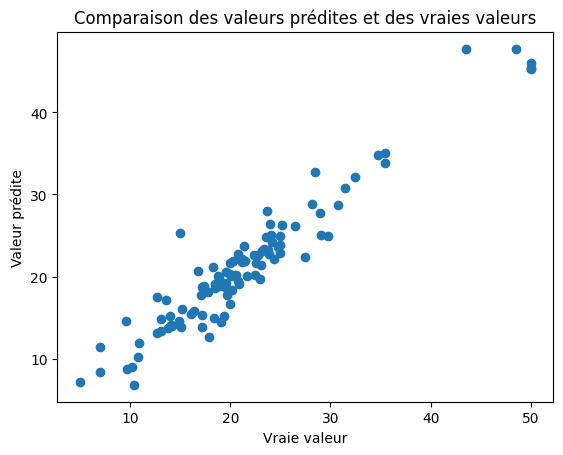

In [84]:
import matplotlib.pyplot as plt

# Obtenir les valeurs prédites du modèle
y_pred = trained_model_gbr2.predict(X_test)

# Tracer le graphique
plt.scatter(y_test, y_pred)
plt.xlabel('Vraie valeur')
plt.ylabel('Valeur prédite')
plt.title('Comparaison des valeurs prédites et des vraies valeurs')
plt.show()
